In [2]:
import pandas as pd
from OpenDutchWordnet import Wn_grid_parser
import argparse
import re
import nltk
import xgboost
import re
import numpy as np
# import stanza
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import scale
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
def clean_text(text):
    if not isinstance(text, str):
        print(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    no_emoji = emoji_pattern.sub(r'', text)
    
    # Remove urls
    no_urls = re.sub(r"http\S+", "", no_emoji)
    
    # Remove punctuation, numbers and symbols
    no_punct_symbols_nrs = re.sub(r'[^A-Za-z\s]+', '', no_urls)
    
    # Remove trailing white space
    no_trailing_ws = " ".join(no_punct_symbols_nrs.split())
    
    # Lowercase
    text_clean = no_trailing_ws.lower()
    return text_clean

def lemmatize(nlp, text):
    doc = nlp(text)
    lemmatized = [word.lemma for sent in doc.sentences for word in sent.words]
    return lemmatized

In [4]:
def process_data(nlp, df_train, df_test):
    # Clean text
    df_train['clean_text'] = df_train['text'].apply(lambda x: clean_text(x))

    # Remove empty values
    df_train = df_train[df_train['clean_text'] != '']

    # Lemmatize 
    df_train['lemmatized_clean_text'] = df_train['clean_text'].apply(lambda x: lemmatize(nlp, x))    

    df_test['clean_text'] = df_test['message'].apply(lambda x: clean_text(x))
    df_test = df_test[df_test['clean_text'] != '']        
    df_test['lemmatized_clean_text'] = df_test['clean_text'].apply(lambda x: lemmatize(nlp, x))  
    
    # Binary labels
    df_test['labels'].replace({"y": 1, "n": 0}, inplace=True)
    return df_train, df_test

In [5]:
def get_hypernyms (instance, synset_id, hypers):
    synset = instance.synsets_find_synset(synset_id)
    if synset:
        hypernyms = synset.get_relations("has_hyperonym")
        if hypernyms:
            for h in hypernyms:
                if (h):
                    if not h.get_target() in hypers:
                        hypers.append(h.get_target())
                        get_hypernyms(instance, h.get_target(), hypers)


def get_hypernyms_lemmas():
    # ['ontmoeten',
    #  'voelen',
    #  'meemaken',
    #  'ondervinden',
    #  'ondergaan',
    #  'gevoelen',
    #  'zich omkleden',
    #  'ervaren',
    #  'gewaarworden',
    #  'kenteren',
    #  'doorleven',
    #  'veranderen',
    #  'keren',
    #  'beleven']
    instance = Wn_grid_parser(path_wn_grid_lmf='odwn_orbn_gwg-LMF_1.3.xml.gz')
    le_el = instance.les_find_le("voelen-v-2")
    synset_el = instance.synsets_find_synset(le_el.get_synset_id())
    hypers = []
    get_hypernyms(instance, synset_el.get_id(), hypers)
    new_hypers = []

    lemmas = []
    for hyper in hypers:
        new_hypers.append(hyper)
        for le in instance.les_all_les_of_one_synset(hyper):
            lemmas.append(le.get_lemma())  

    for hyper in new_hypers:
        hypers = []
        get_hypernyms(instance, hyper, hypers)
        new_hypers = []
        for hyper in hypers:
            new_hypers.append(hyper)
            for le in instance.les_all_les_of_one_synset(hyper):
                lemmas.append(le.get_lemma())
                
    return list(set(lemmas+['voelen']))

In [6]:
def check_match(match, clean_text):
    if re.search(match, clean_text):
        return 1
    else: 
        return 0
    
def lemma_replace(word_list, clean_text, lemmatized_clean_text):
    clean_text_tokenized = clean_text.split()
    for lemma_word in word_list:
        if lemma_word in lemmatized_clean_text:
            for i, word in enumerate(lemmatized_clean_text.split()):
                if word == lemma_word:
                    clean_text_tokenized[i] = clean_text_tokenized[i].replace(clean_text_tokenized[i], lemma_word)
    clean_text = " ".join(clean_text_tokenized)
    return clean_text

def heuristics_labelling(df_train, df_test, WN_synsets, filters, remove):
    
    df_train['clean_text_lemma'] = df_train['clean_text']
    df_test['clean_text_lemma'] = df_test['clean_text']
    
    matches = []
    if 0 in filters:
        matches.append("((heb|heeft|hebben) [a-z]* (gehad))")
    if 1 in filters:
        direct_relation = 'vader|moeder|ouder|schoonvader|schoonmoeder|kind|zoon|dochter|man|vrouw|broer|zus|neef|nicht|tante|oom'
        df_train['clean_text_lemma'] = df_train[['clean_text', 'lemmatized_clean_text']].apply(lambda x: lemma_replace(direct_relation.split('|'), x.clean_text, x.lemmatized_clean_text), axis=1)
        df_test['clean_text_lemma'] = df_test[['clean_text', 'lemmatized_clean_text']].apply(lambda x: lemma_replace(direct_relation.split('|'), x.clean_text, x.lemmatized_clean_text), axis=1)
        
        matches.append("((mijn|mn|me|m n|mij|men) " + '(' + direct_relation + '))') 
                       
    if 2 in filters:                       
        df_train['clean_text_lemma'] = df_train[['clean_text', 'lemmatized_clean_text']].apply(lambda x: lemma_replace(WN_synsets, x.clean_text, x.lemmatized_clean_text), axis=1)
        df_test['clean_text_lemma'] = df_test[['clean_text', 'lemmatized_clean_text']].apply(lambda x: lemma_replace(WN_synsets, x.clean_text, x.lemmatized_clean_text), axis=1)
                
        matches.append('('+'|'.join(WN_synsets)+')')

    match = '|'.join(matches)
    df_train['labels'] = df_train['clean_text_lemma'].apply(lambda x: check_match(match, x))
    df_test['predicted'] = df_test['clean_text_lemma'].apply(lambda x: check_match(match, x))
      
    if remove == True:
        df_train['clean_text_removals'] = df_train['clean_text_lemma'].apply(lambda x: re.sub(match, '', x))
        df_test['clean_text_removals'] = df_test['clean_text_lemma'].apply(lambda x: re.sub(match, '', x))

In [7]:
def resample_data(df_train, df_train_labels):
    over = RandomOverSampler(sampling_strategy=1, random_state=42)
    df_train_sampled, df_train_sampled_labels = over.fit_resample(df_train, df_train_labels)
    return df_train_sampled


In [8]:
def create_train_test(df_train, df_test, vectorizer, remove):
    vect = vectorizer
    y_train = df_train['labels']
    y_test = df_test['labels']
    if remove == True:
        corpus = df_train['clean_text_removals'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text_removals'])
    else:
        corpus = df_train['clean_text'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text'])
    return X_train, y_train, X_test, y_test

In [9]:
def create_train_test_unlabelled(df_train, df_test, vectorizer, remove):
    vect = vectorizer
    y_train = df_train['labels']
    if remove == True:
        corpus = df_train['clean_text_removals'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text_removals'])
    else:
        corpus = df_train['clean_text'].tolist()
        X_train = vect.fit_transform(corpus)
        X_test = vect.transform(df_test['clean_text'])
    return X_train, y_train, X_test

In [10]:
def create_cm(true_labels, predicted_labels):
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
        
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    colorbar=False,
                                    show_absolute=False,
                                    show_normed=True,
                                    class_names=['non-exp','exp'])
    fig.set_size_inches(10, 10.5)

    
def class_feature_importance(X, Y, feature_importances, vect):
    N, M = X.shape
    X = scale(X, with_mean=False)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(vect.get_feature_names(), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out    

def classification_experiments(X_train, y_train, X_test, y_test):
    print("--------------------------------")
    print("Logistic Regression")
    
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("LR: ROC-AUC:", roc_auc_score(y_test, y_pred))
#     create_cm(y_test, y_pred)
    
    print("--------------------------------")
    print("XGBoost Random Forest")
    
    xgbc = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss')
    xgb = xgbc.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("XGB: ROC-AUC:", roc_auc_score(y_test, y_pred))
#     create_cm(y_test, y_pred)

In [11]:
def full_data_train_test_split(full_df, sub_df, test_df):
    test_ids = test_df['object_id'].tolist()
    sub_ids = sub_df['object_id'].tolist()
    print(len(full_df))
    full_df = full_df[~full_df.object_id.isin(test_ids)]
    print(len(full_df))
    full_df = full_df[~full_df.object_id.isin(sub_ids)]
    print(len(full_df))
    sub_df = sub_df[~sub_df.object_id.isin(test_ids)]
    print(len(sub_df))
    # full_df_test is for prediction
    full_df_train_no_sentiment, full_df_test = train_test_split(full_df, test_size=0.42, random_state=42)
    print(len(full_df_train_no_sentiment))
    full_df_train = pd.concat([full_df_train_no_sentiment, sub_df]) #sub_df  is around 2 percent
    return full_df_train, full_df_test

In [12]:
def create_predicted(unlabelled_df, unlabelled_X_test, best_model, name):
    predictions = best_model.predict_proba(unlabelled_X_test)
    unlabelled_df['best_model_pred'] = predictions
    unlabelled_df[['text', 'best_model_pred']].to_csv(name+'.tsv', sep='\t', index=False)

In [13]:
# df_train = pd.read_csv('lemmatized_train_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
# sub_df = pd.read_csv('lemmatized_train_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
# df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')

# df_train, df_unlabelled = full_data_train_test_split(df_train, sub_df, df_test)
# print(len(df_train))
# print(len(df_unlabelled))


In [14]:
def create_lemmatized_files():
    df_train = pd.read_csv('fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')
    df_test = pd.read_csv('experience_test/Fb_random_sample_500_annotated_discussed.tsv', sep='\t')
    sub_df = pd.read_csv('high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')
    
    df_train = df_train[~df_train['text'].isna()]
    df_test = df_test[~df_test['message'].isna()]
    sub_df = sub_df[~sub_df['text'].isna()]
    
    nlp = stanza.Pipeline(lang='nl', processors='tokenize,pos,lemma')
    df_train_sent, df_test_sent = process_data(nlp, sub_df, df_test)
    print("Finished sentiment")
    df_train, df_test = process_data(nlp, df_train, df_test)
    print("Finished train and test")
 
    df_test_sent.to_csv('lemmatized_test_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_train_sent.to_csv('lemmatized_train_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')

    df_train.to_csv('lemmatized_train_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t') # no test 
    df_test.to_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    

In [15]:
def results_models():
    # comment this when not using unlabelled    
    df_train = pd.read_csv('lemmatized_train_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    sub_df = pd.read_csv('lemmatized_train_high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    
    df_train, df_unlabelled = full_data_train_test_split(df_train, sub_df, df_test)
    df_train.to_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t') 
    df_unlabelled.to_csv('lemmatized_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')

    df_train = pd.read_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')
#     df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')

    WN_synsets = get_hypernyms_lemmas()
    
    vectorizers = [TfidfVectorizer(), CountVectorizer(binary=True)]
    removes = [False, True]
    filters = [[0], [1], [2], [0, 1], [1, 2], [0, 2], [0, 1, 2]]
    for vect in vectorizers:
        print(vect)
        print('-----------------')
        for remove in removes:
            print(remove)
            print('-----------------')
            for filter_ in filters:
                print(filter_)
                print('-------------------')
                heuristics_labelling(df_train, df_test, WN_synsets, filter_, remove)
                print('DATA STATS: ', df_train['labels'].value_counts())

                df_train_sampled = resample_data(df_train, df_train['labels'])
                X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, vect, remove)
                print('-------------------')
                print("BASELINE")
                print(classification_report(df_test['labels'], df_test['predicted']))
                classification_experiments(X_train, y_train, X_test, y_test)

In [16]:
def prediction_labelling(df_train, df_test, df_unlabelled_test, WN_synsets, best_xgb):
    # Best XGB 
    heuristics_labelling(df_train, df_unlabelled_test, WN_synsets, [0,1,2], False)
    df_train_sampled = resample_data(df_train, df_train['labels'])
    bin_vect = CountVectorizer(binary=True)
    X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, bin_vect, False)

    _, _, unlabelled_X_test = create_train_test_unlabelled(df_train_sampled, df_unlabelled_test, bin_vect, False)
    
    predictions = best_xgb.predict_proba(unlabelled_X_test)[:, 1]
    predictions_labels = best_xgb.predict(unlabelled_X_test)

    df_unlabelled_test['best_model_pred'] = predictions
    df_unlabelled_test['best_model_pred_labels'] = predictions_labels
#     df_unlabelled_test[['text', 'best_model_pred']].to_csv('predicted_data/unlabelled_predictions_by_xgb-binary-keepfeat-1.tsv', sep='\t', index=False)
    df_unlabelled_test[['text', 'best_model_pred', 'best_model_pred_labels']].to_csv('corrections/unlabelled_prediction_labels_by_xgb-binary-keepfeat-1.tsv', sep='\t', index=False, header=None)

def best_xgb_results(df_train, df_test, WN_synsets):
    heuristics_labelling(df_train, df_test, WN_synsets, [0,1,2], False)
    df_train_sampled = resample_data(df_train, df_train['labels'])
    bin_vect = CountVectorizer(binary=True)
    X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, bin_vect, False)
    best_xgb = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss').fit(X_train, y_train)  
    y_pred = best_xgb.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    importance = best_xgb.feature_importances_

    result = class_feature_importance(X_test.toarray(), y_pred, importance, bin_vect)

    d = result.get(1)

    sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)
    print(sorted_d[:20])
    
    return best_xgb, y_pred, y_test
    
def best_lr_results(df_train, df_test, WN_synsets):
    heuristics_labelling(df_train, df_test, WN_synsets, [0,1,2], True)
    df_train_sampled = resample_data(df_train, df_train['labels'])
    tfidf = TfidfVectorizer()
    X_train, y_train, X_test, y_test = create_train_test(df_train_sampled, df_test, tfidf, False)
    clf = LogisticRegression(random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Logistic Regression")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    importance = clf.coef_[0]

    result = class_feature_importance(X_test.toarray(), y_pred, importance, tfidf)

    d = result.get(1)

    sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)

    print(sorted_d[:20])
    
    return clf, y_pred, y_test

In [17]:
def create_sample_dfs():
    bm_df = pd.read_csv('predicted_data/unlabelled_predictions_by_xgb-binary-keepfeat-1.tsv', sep='\t', header=None)
#     bm_df[:250].to_csv('predicted_data/top-250-unlabelled_predictions_by_xgb-binary-keepfeat.tsv', sep='\t', header=False)

#     bm_df_unlabelled = bm_df.fillna('Unlabelled')
#     labelled = bm_df_unlabelled[bm_df_unlabelled[3] != 'Unlabelled']
#     labelled[[0, 1, 3]].to_csv('predicted_data/workshop_labelled_predictions_by_xgb-binary-keepfeat-1.csv', sep='\t', header=False)

#     bm_df_unlabelled = bm_df[~bm_df[1].isin(labelled.index)]
#     above_unlabelled_09 = bm_df_unlabelled[bm_df_unlabelled[1] >= 0.9]
#     above_unlabelled_09_sample = above_unlabelled_09.sample(n=250, random_state=50)
#     above_unlabelled_09_sample[[0]].to_csv('predicted_data/sample_unlabelledpredictions_over0-9_by_xgb-binary-keepfeat-1.csv', sep='\t', header=False, index=False)
    
#     below_unlabelled_09 = bm_df_unlabelled[bm_df_unlabelled[1] < 0.9]
#     below_unlabelled_09 = below_unlabelled_09[below_unlabelled_09[1] >= 0.5]
#     below_unlabelled_09_sample = below_unlabelled_09.sample(n=250, random_state=50)
#     below_unlabelled_09_sample[[0]].to_csv('predicted_data/sample_unlabelledpredictions_below0-9_by_xgb-binary-keepfeat-1.csv', sep='\t', header=False, index=False)

    above_unlabelled_09 = bm_df[bm_df[1] >= 0.9]
    above_unlabelled_09_sample = above_unlabelled_09.sample(n=250, random_state=50)
    above_unlabelled_09_sample[[0]].to_csv('predicted_data/sample_unlabelledpredictions_over0-9_by_xgb-binary-keepfeat-1.csv', sep='\t', header=False, index=False)
    
    below_unlabelled_09 = bm_df[bm_df[1] < 0.9]
    below_unlabelled_09 = below_unlabelled_09[below_unlabelled_09[1] >= 0.5]
    below_unlabelled_09_sample = below_unlabelled_09.sample(n=250, random_state=50)
    below_unlabelled_09_sample[[0]].to_csv('predicted_data/sample_unlabelledpredictions_below0-9_by_xgb-binary-keepfeat-1.csv', sep='\t', header=False, index=False)


In [18]:
def correct_preds_index(y_test, y_pred):
    return [1 if i == j else 0 for i, j in zip(y_test, y_pred)]

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
lr

LogisticRegression(random_state=42)

In [29]:
# lr.coef_.shape[-1]
len(xgb.feature_importances_)

68953

In [21]:
df_train = pd.read_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')
df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
df_unlabelled_test = pd.read_csv('lemmatized_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')
WN_synsets = get_hypernyms_lemmas()

#     create_lemmatized_files()
#     results_models()
print("LR")
lr, y_pred_lr, y_test = best_lr_results(df_train, df_test, WN_synsets)
# lr_correct = correct_preds_index(y_test, y_pred_lr)

print("XGB")
xgb, y_pred_xgb, y_test = best_xgb_results(df_train, df_test, WN_synsets)
# xgb_correct = correct_preds_index(y_test, y_pred_xgb)

LR
Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       451
           1       0.38      0.49      0.43        49

    accuracy                           0.87       500
   macro avg       0.66      0.70      0.68       500
weighted avg       0.89      0.87      0.88       500

[[412  39]
 [ 25  24]]
[('mijn', 37.5394589326804), ('veranderen', 15.195921665435964), ('voelen', 14.143905054037504), ('moeder', 10.696318957685547), ('gehad', 8.160789016091105), ('en', 7.0674213730451445), ('ouders', 6.775077811674564), ('vader', 6.226580536516842), ('kind', 5.317612302921842), ('de', 4.173522355097137), ('kinderen', 4.117563336583467), ('dochter', 3.9191108606087375), ('mn', 3.5923236220597317), ('heb', 3.2703007162048428), ('ontmaskeren', 3.1096909578192182), ('ook', 3.062119901102135), ('ik', 2.8111040196731327), ('van', 2.7796139972246197), ('ondervinden', 2.6695382279199324), ('te', 2.6206176149749996)]
XGB
         

In [20]:
def main():
    df_train = pd.read_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')
    df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
    df_unlabelled_test = pd.read_csv('lemmatized_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')
    WN_synsets = get_hypernyms_lemmas()
    
#     create_lemmatized_files()
    results_models()
    print("LR")
    lr, y_pred_lr, y_test = best_lr_results(df_train, df_test, WN_synsets)
    lr_correct = correct_preds_index(y_test, y_pred_lr)
    
    print("XGB")
    xgb, y_pred_xgb, y_test = best_xgb_results(df_train, df_test, WN_synsets)
    xgb_correct = correct_preds_index(y_test, y_pred_xgb)


    print("correct matrix")
    print(confusion_matrix(lr_correct, xgb_correct))
    
    print("prediction matrix")
    print(confusion_matrix(y_pred_lr, y_pred_xgb))
    
    prediction_labelling(df_train, df_test, df_unlabelled_test, WN_synsets, xgb)
    create_sample_dfs()
    

In [22]:
new_below = pd.read_csv('predicted_data/sample_unlabelledpredictions_below0-9_by_xgb-binary-keepfeat-1.csv', sep='\t', header=None)
new_above = pd.read_csv('predicted_data/sample_unlabelledpredictions_over0-9_by_xgb-binary-keepfeat-1.csv', sep='\t', header=None)
old_below = pd.read_csv('predicted_data/sample_unlabelledpredictions_below0-9_by_xgb-binary-keepfeat.tsv', sep='\t', header=None)
old_above = pd.read_csv('predicted_data/sample_unlabelledpredictions_over0-9_by_xgb-binary-keepfeat.tsv', sep='\t', header=None)



In [31]:
df_test = pd.read_csv('experience_test/Fb_random_sample_500_annotated_discussed.tsv', sep='\t')
df_test['Experience knowledge & value considerations yes / no (S)'].value_counts()

n    449
y     51
Name: Experience knowledge & value considerations yes / no (S), dtype: int64

In [36]:
df_train = pd.read_csv('lemmatized_train_no_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')
df_test = pd.read_csv('lemmatized_test_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.tsv', sep='\t')
df_unlabelled_test = pd.read_csv('lemmatized_unlabelled_fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb-1.tsv', sep='\t')

WN_synsets = get_hypernyms_lemmas()

xgb, y_pred_xgb, y_test = best_xgb_results(df_train, df_test, WN_synsets)

prediction_labelling(df_train, df_test, df_unlabelled_test, WN_synsets, xgb)


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.95      0.90      0.92       451
           1       0.36      0.55      0.44        49

    accuracy                           0.86       500
   macro avg       0.66      0.72      0.68       500
weighted avg       0.89      0.86      0.87       500

[[404  47]
 [ 22  27]]


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('mijn', 0.07606954745757265), ('en', 0.040133188615727136), ('gehad', 0.015218279679826183), ('het', 0.015060751687811774), ('die', 0.01478758952494729), ('voelen', 0.013125200847761283), ('veranderen', 0.011746545175977015), ('ook', 0.010378894536077793), ('de', 0.01019848904808294), ('te', 0.007089895940134645), ('in', 0.0069052894501721186), ('moeder', 0.006366589741507317), ('is', 0.005035260734763819), ('we', 0.004713656978421391), ('heb', 0.004007162248918236), ('ik', 0.0033331273668041977), ('ze', 0.003281975484730183), ('best', 0.0030982258200012262), ('zijn', 0.0030839834713933677), ('man', 0.0028300290842856422)]


In [47]:
bm_df = pd.read_csv('corrections/unlabelled_prediction_labels_by_xgb-binary-keepfeat-1.tsv', sep='\t', header=None)
below = pd.merge(bm_df, old_below, how='inner', on=[0])
above = pd.merge(bm_df, old_above, how='inner', on=[0])
# bm_df[2].value_counts()
pd.concat([above, below])[2].value_counts()

1    435
0     65
Name: 2, dtype: int64

In [39]:
bm_df = pd.read_csv('predicted_data/unlabelled_predictions_by_xgb-binary-keepfeat-1.tsv', sep='\t', header=None)
below = pd.merge(bm_df, old_below, how='inner', on=[0])
above = pd.merge(bm_df, old_above, how='inner', on=[0])

,0,1
0,"1. AD 2016 griep, (zie Google) zelfde symptome...",0.999988
1,"TC Ferhat Ik ben ettelijke malen ingeent, en i...",0.999959
2,Soraya van Berkel Deze oproep geldt voor elke...,0.999935
3,"Deze oproep geldt voor elke land, niet alleen ...",0.999935
4,Angelique Raadgever sterk tegenargument. Ik we...,0.999906
...,...,...
48811,Pieter Koopman laten we maar hopen dat onze o...,0.010394
48812,Bedankt zelfs deze mensen die weten meer dan r...,0.010387
48813,Kunnen die ouders niet aanklaagt worden? Dat v...,0.009838
48814,Shie Do jij bent zo maf als een mandje zeker g...,0.009261


In [26]:
above = pd.merge(bm_df, old_above, how='inner', on=[0])
above

,0,1
0,"1. AD 2016 griep, (zie Google) zelfde symptome...",0.999988
1,"Deze oproep geldt voor elke land, niet alleen ...",0.999935
2,Angelique Raadgever sterk tegenargument. Ik we...,0.999906
3,Sandra Haas toen was het minder duidelijk dat ...,0.999838
4,Paula de Gunst mijn vader werd gebeld door de ...,0.999667
...,...,...
245,Kevin Dermaux Hou toch op dwaas. Ze moeten jul...,0.681436
246,"Giny Jonkeren hoe vaak je het ook roept, zodat...",0.654695
247,Kees Beekhuijs Liever dat dan die rommel in mi...,0.625234
248,Dit is verhaal van mij vriendin Elisa Limas Ir...,0.555987


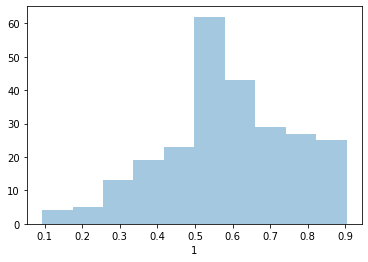

In [56]:
below = pd.merge(bm_df, old_below, how='inner', on=[0])
above = pd.merge(bm_df, old_above, how='inner', on=[0])

data = pd.read_csv('corrections/corrected_500_unlabelled.tsv', sep='\t', header=None)[250:]
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(data[1],bins=10,kde=False)
plt.show()

In [34]:
above = pd.merge(bm_df, old_above, how='inner', on=[0])

In [24]:
bm_df = pd.read_csv('predicted_data/unlabelled_predictions_by_xgb-binary-keepfeat-1.tsv', sep='\t', header=None)
above_unlabelled_09 = bm_df[bm_df[1] >= 0.9]

below_unlabelled_09 = bm_df[bm_df[1] < 0.9]
below_unlabelled_09 = below_unlabelled_09[below_unlabelled_09[1] >= 0.5]


pd.merge(below_unlabelled_09, old_below, how='inner', on=[0])

In [26]:
hhi = pd.merge(bm_df, old_above, how='inner', on=[0])
hhi[hhi[1] >= 0.9]



,0,1
0,"1. AD 2016 griep, (zie Google) zelfde symptome...",0.999988
1,"Deze oproep geldt voor elke land, niet alleen ...",0.999935
2,Angelique Raadgever sterk tegenargument. Ik we...,0.999906
3,Sandra Haas toen was het minder duidelijk dat ...,0.999838
4,Paula de Gunst mijn vader werd gebeld door de ...,0.999667
...,...,...
162,mijn idee is toch om eerst de kwetsbaren te va...,0.515912
163,Martin Derby in mijn ogen nauwelijks. Ik mis v...,0.513940
164,Ik ook niet.. en ken ook weinig in mijn omgevi...,0.513735
165,"Ze moeten deze mensen ook geen vaccin geven , ...",0.510170


In [21]:
hhi = pd.merge(bm_df, old_below, how='inner', on=[0])
hhi = hhi[hhi[1] < 0.9]
hhi[hhi[1] >= 0.5]

,0,1
19,Die zijn gestoord je ongeboren kind als proefk...,0.899963
20,Pepijn Noordenbos ja en daarna wordt je weer b...,0.893348
21,Waarom moeten gezonde mensen een vaccine nemen...,0.891940
22,Mario Kapitein Echt...denk jij nu SERIEUS dat...,0.889166
23,Yolanda Truyen ik heb vorig jaar maart corona ...,0.887496
...,...,...
181,mijn idee is toch om eerst de kwetsbaren te va...,0.515912
182,Martin Derby in mijn ogen nauwelijks. Ik mis v...,0.513940
183,Ik ook niet.. en ken ook weinig in mijn omgevi...,0.513735
184,"Ze moeten deze mensen ook geen vaccin geven , ...",0.510170


In [7]:
pd.merge(above_unlabelled_09, old_above, how='inner', on=[0])

,0,1
0,"1. AD 2016 griep, (zie Google) zelfde symptome...",0.999988
1,"Deze oproep geldt voor elke land, niet alleen ...",0.999935
2,Angelique Raadgever sterk tegenargument. Ik we...,0.999906
3,Sandra Haas toen was het minder duidelijk dat ...,0.999838
4,Paula de Gunst mijn vader werd gebeld door de ...,0.999667
...,...,...
228,Vind ik ook. Heb me wel weer laten inenten. Ma...,0.906661
229,Joops Eersel QEnergy alleen de antistoffen bli...,0.905045
230,Wanneer flikkeren jullie op met deze dagelijk...,0.904138
231,Mariska Berkelaar-Smit heb in een zwaar gerefo...,0.903586


In [67]:
if __name__ == "__main__":
    main()
    

LR
Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       451
           1       0.38      0.49      0.43        49

    accuracy                           0.87       500
   macro avg       0.66      0.70      0.68       500
weighted avg       0.89      0.87      0.88       500

[[412  39]
 [ 25  24]]
[('mijn', 37.5394589326804), ('veranderen', 15.195921665435964), ('voelen', 14.143905054037504), ('moeder', 10.696318957685547), ('gehad', 8.160789016091105), ('en', 7.0674213730451445), ('ouders', 6.775077811674564), ('vader', 6.226580536516842), ('kind', 5.317612302921842), ('de', 4.173522355097137), ('kinderen', 4.117563336583467), ('dochter', 3.9191108606087375), ('mn', 3.5923236220597317), ('heb', 3.2703007162048428), ('ontmaskeren', 3.1096909578192182), ('ook', 3.062119901102135), ('ik', 2.8111040196731327), ('van', 2.7796139972246197), ('ondervinden', 2.6695382279199324), ('te', 2.6206176149749996)]
XGB
         